PU comparison

In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Load data

In [5]:
dataDir = '../data/cmsMC_private/'
dataDir += 'BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU0_10-2-3/'
dataDir += '/ntuples_B2JpsiKst'
datasets_loc = glob(dataDir + '/out_CAND_*.root')
len(datasets_loc)

182

In [6]:
f = datasets_loc[0]
t = ur.open(f)['outA']['Tevts']
# print tMC.keys(), '\n\n'
branches = t.keys()
for b in np.sort(branches):
#     pass
    print b

B_mumupiK_cBMass_eta
B_mumupiK_cBMass_phi
B_mumupiK_cBMass_pt
B_mumupiK_eta
B_mumupiK_phi
B_mumupiK_pt
Jpsi_eta
Jpsi_phi
Jpsi_pt
KRefit_eta
KRefit_phi
KRefit_pt
K_N_valid_hits
K_eta
K_norm_chi2
K_phi
K_pt
K_sigdxy_PV
Kst_eta
Kst_phi
Kst_pt
LumiBlock
MC_B_P
MC_B_eta
MC_B_phi
MC_B_pt
MC_Jpsi_P
MC_Jpsi_eta
MC_Jpsi_phi
MC_Jpsi_pt
MC_K_P
MC_K_eta
MC_K_phi
MC_K_pt
MC_Kst_P
MC_Kst_eta
MC_Kst_phi
MC_Kst_pt
MC_mu_IP
MC_mu_P
MC_mu_eta
MC_mu_phi
MC_mu_pt
MC_mum_P
MC_mum_eta
MC_mum_phi
MC_mum_pt
MC_mup_P
MC_mup_eta
MC_mup_phi
MC_mup_pt
MC_pi_P
MC_pi_eta
MC_pi_phi
MC_pi_pt
N_trgMu
N_vertexes
Run
chi2_mumu
chi2_mumupiK
chi2_mumupiK_cBMass
chi2_piK
cosT_Jpsi_PV
cosT_Kst_PV
cos_B_PV_mumupiK
cos_B_PV_mumupiK_cBMass
cos_Jpsi_PV
cos_Kst_PV
d_vtxJpsi_PV
d_vtxKst_PV
dof_mumu
dof_mumupiK
dof_mumupiK_cBMass
dof_piK
eventNumber
isGood_mumupiK
isGood_mumupiK_cBMass
isValid_mumupiK
isValid_mumupiK_cBMass
mass_KK
mass_mumu
mass_mumupiK
mass_mumupiK_cBMass
mass_piK
mass_piK_CPconj
mumRefit_eta
mumRefit_phi
mumRef

In [7]:
d = extarct_multiple(datasets_loc, branches=branches, flag='data')
print 'Number of events:', d['n_B'].shape[0]
print 'Number of candidates:', d['mass_mumupiK'].shape[0]

Number of events: 592375
Number of candidates: 691974


In [8]:
print 'Number of candidates:', d['mass_mumupiK'].shape[0]

Number of candidates: 691974


In [9]:
dataDir = '../data/cmsMC_private/'
dataDir += 'BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3/'
dataDir += '/jobs_B2JpsiKst'
datasets_loc_PU = glob(dataDir + '/out_CAND_*.root')
len(datasets_loc_PU)

163

In [10]:
dPU = extarct_multiple(datasets_loc_PU, branches=branches, flag='data')
print 'Number of events:', dPU['n_B'].shape[0]
print 'Number of candidates:', dPU['mass_mumupiK'].shape[0]

Number of events: 186113
Number of candidates: 246425


# Cuts declaration

In [11]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

def createSel(d, cut):
    k_ref = cut.keys()[0]
    if k_ref[0] == '_': 
            k_ref = k_ref[1:]
    sel = np.ones_like(d[k_ref], dtype=bool)
    for k, v in cut.iteritems():
        if k[0] == '_': 
            k = k[1:]
        sel = np.logical_and(sel, ops[v[0]](d[k], v[1]) )
        
    eff = np.sum(sel)/float(sel.shape[0])
    return sel, eff

# Selection

In [12]:
cut = {}

####----- Trigger-like cuts -----#
cut['mum_pt'] = ['>', 3.5]
cut['mup_pt'] = ['>', 3.5]
# cut['Jpsi_pt'] = ['>', 6.9]
cut['sigdxy_vtxJpsi_PV'] = ['>', 3]
cut['pval_mumu'] = ['>', 0.1]
cut['mum_eta'] = ['>', -2.2]
cut['mup_eta'] = ['>', -2.2]
cut['_mum_eta'] = ['<', 2.2]
cut['_mup_eta'] = ['<', 2.2]
# Missing: dca_mumu < 0.5 cm
cut['cos_Jpsi_PV'] = ['>', 0.9]

####----- Muon systems cuts -----#
cut['mum_dxy'] = ['<', 3]
cut['mup_dxy'] = ['<', 3]

####----- Hadron systems cuts -----#
cut['K_pt'] = ['>', 0.8]
cut['pi_pt'] = ['>', 0.8]
cut['K_sigdxy_PV'] = ['>', 2]
cut['pi_sigdxy_PV'] = ['>', 2]
cut['cos_Kst_PV'] = ['>', 0.9]
cut['pval_piK'] = ['>', 0.1]

In [13]:
sel_prelim, eff = createSel(d, cut)

n_B_cand = np.repeat(d['n_B'], d['n_B'].astype(np.int))
sel_prelim = np.logical_and(sel_prelim, n_B_cand==1)

eff = float(np.sum(sel_prelim))/sel_prelim.shape[0]

print eff

0.411080474122


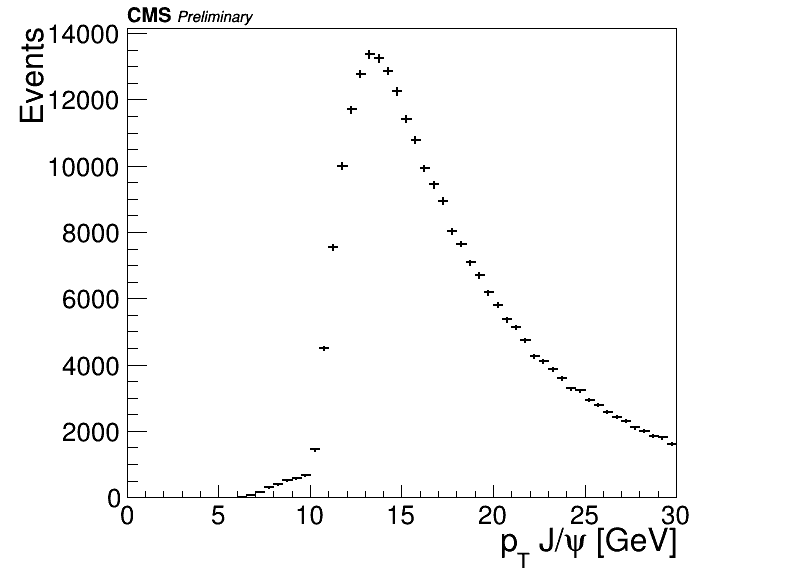

In [14]:
h = create_TH1D(d['Jpsi_pt'][sel_prelim], 
                title='',
                axis_title=['p_{T} J/#psi [GeV]', 'Events'],
                binning=[60, 0, 30]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
c.Draw()

In [15]:
cut['Jpsi_pt'] = ['>', 10]

In [16]:
sel_prelim, eff = createSel(d, cut)
print 'No PU eff:', eff
sel_prelimPU, eff = createSel(dPU, cut)
print 'Eff w/ PU:', eff

No PU eff: 0.481113452239535
Eff w/ PU: 0.29478340265800956


# Muon system

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


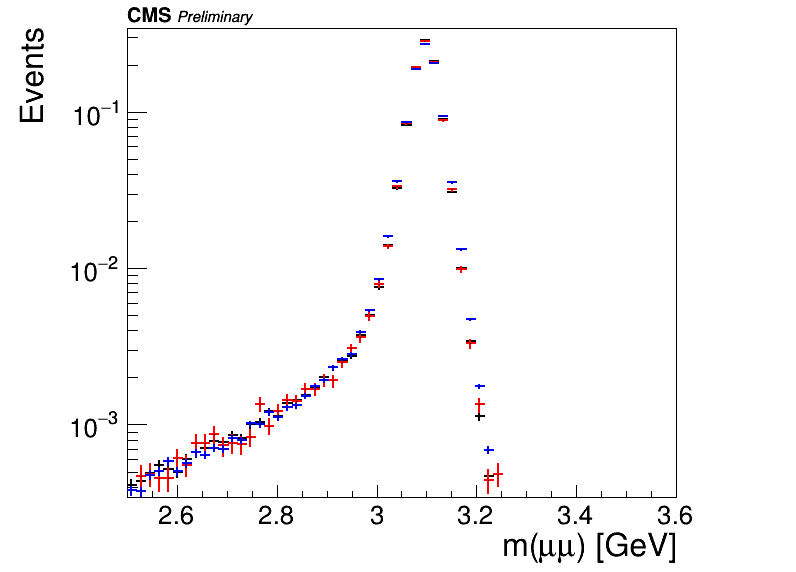

In [18]:
h = create_TH1D(d['mass_mumu'][sel_prelim], 
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[60, 2.5, 3.6]
               )
h.Sumw2()
h.Scale(1./h.Integral())

h2 = create_TH1D(dPU['mass_mumu'][sel_prelimPU], 
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[60, 2.5, 3.6]
               )
h2.Sumw2()
h2.SetLineColor(2)
h2.Scale(1./h2.Integral())

sel_ExistB = d['pval_mumupiK']>0.1
h3 = create_TH1D(d['mass_mumu'][sel_ExistB], 
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[60, 2.5, 3.6]
               )
h3.Sumw2()
h3.SetLineColor(rt.kBlue)
h3.Scale(1./h3.Integral())
  
    
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
c.SetRightMargin(0.15)
c.Draw()
c.SetLogy()
h.GetYaxis().SetRangeUser(0.9, 1.2*h.GetMaximum())

# Hadron system

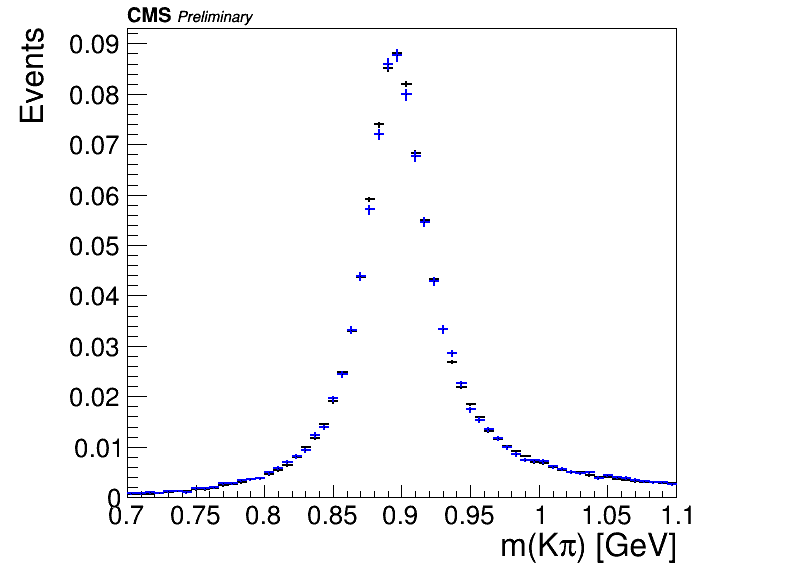

In [19]:
h = create_TH1D(d['mass_piK'][sel_prelim], 
                title='',
                axis_title=['m(K#pi) [GeV]', 'Events'],
                binning=[60, 0.7, 1.1]
               )
h.Sumw2()
h.Scale(1./h.Integral())


h3 = create_TH1D(dPU['mass_piK'][sel_prelimPU], 
                title='',
                axis_title=['m(K#pi) [GeV]', 'Events'],
                binning=[60, 0.7, 1.1]
               )
h3.Sumw2()
h3.SetLineColor(rt.kBlue)
h3.Scale(1./h3.Integral())

                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h3], 'same')
c.SetRightMargin(0.15)
c.Draw()
# c.SetLogy()

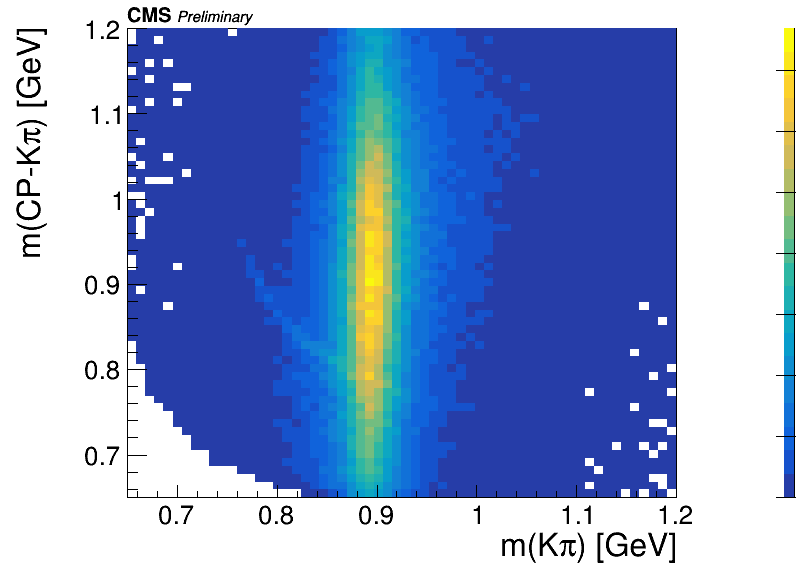

In [20]:
h = create_TH2D(np.column_stack((d['mass_piK'][sel_prelim], d['mass_piK_CPconj'][sel_prelim])),
                title='',
                axis_title=['m(K#pi) [GeV]', 'm(CP-K#pi) [GeV]', 'Events'],
                binning=[60, 0.65, 1.2, 60, 0.65, 1.2]
               )
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.Draw()
# c.SetLogy()

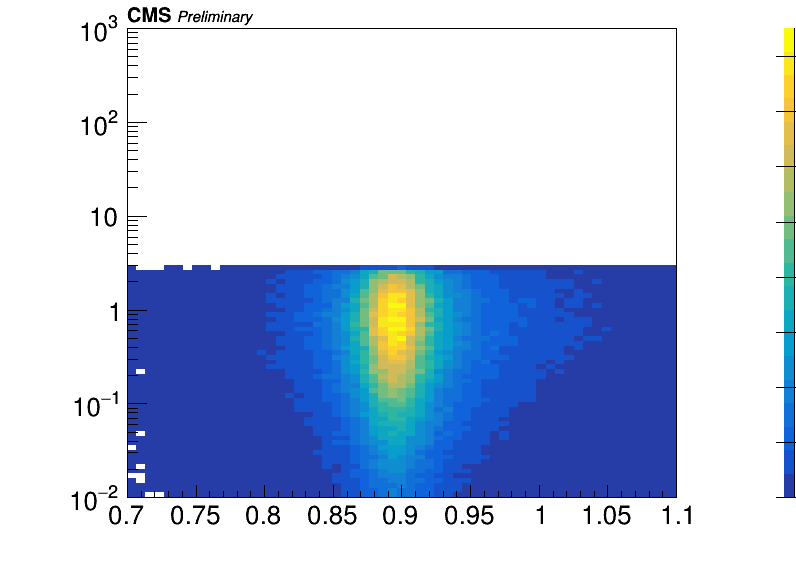

In [21]:
h = create_TH2D(np.column_stack((d['mass_piK'][sel_prelim], d['chi2_piK'][sel_prelim])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(0.7, 1.1, 60), np.logspace(-2, 3, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

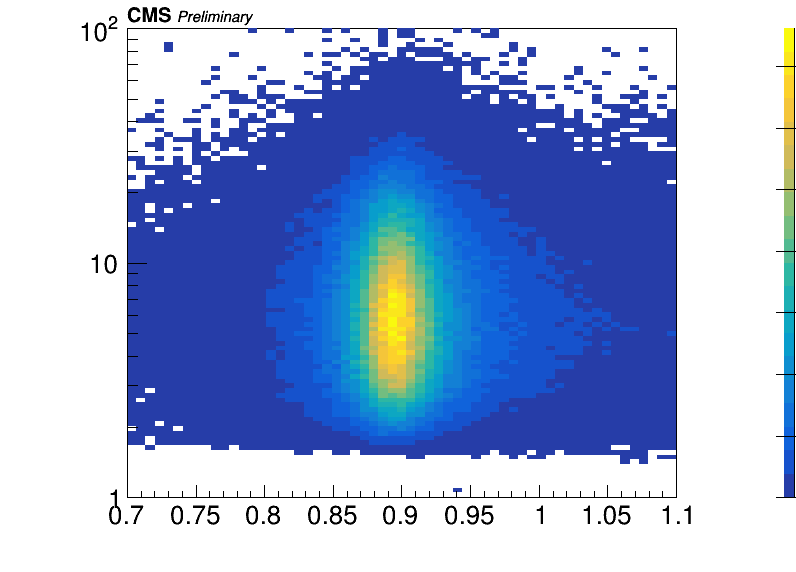

In [22]:
h = create_TH2D(np.column_stack((d['mass_piK'][sel_prelim], d['Kst_pt'][sel_prelim])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(0.7, 1.1, 60), np.logspace(0, 2, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

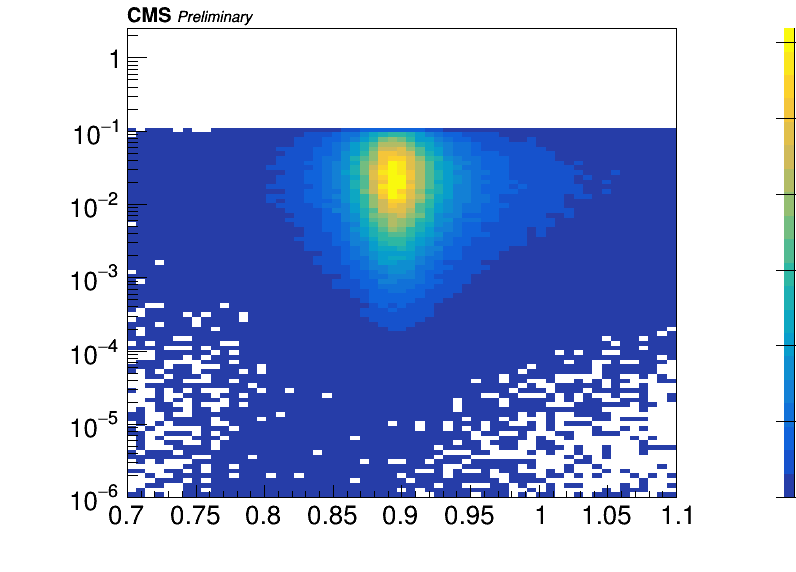

In [23]:
h = create_TH2D(np.column_stack((d['mass_piK'][sel_prelim], 1-d['cos_Kst_PV'][sel_prelim])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(0.7, 1.1, 60), np.logspace(-6, 0.4, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

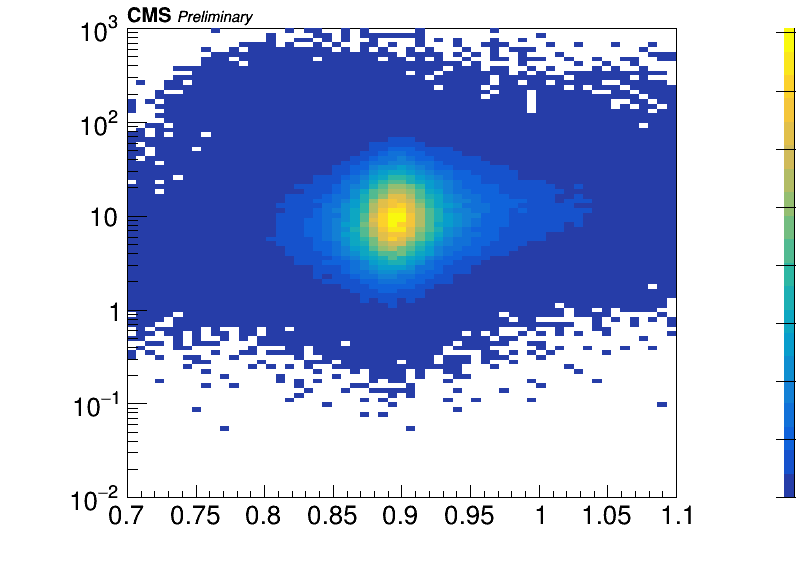

In [24]:
h = create_TH2D(np.column_stack((d['mass_piK'][sel_prelim], d['sigd_vtxKst_PV'][sel_prelim])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(0.7, 1.1, 60), np.logspace(-2, 3, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

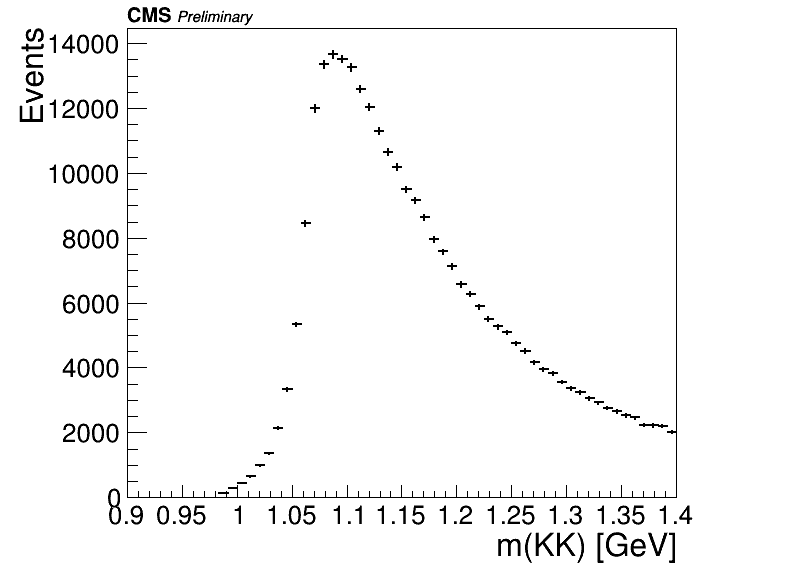

In [25]:
h = create_TH1D(d['mass_KK'][sel_prelim], 
                title='',
                axis_title=['m(KK) [GeV]', 'Events'],
                binning=[60, 0.9, 1.4]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
c.Draw()

# Full analysis

In [26]:
cut['mass_KK'] = ['>',  1.035] #reject the phi->KK
cut['mass_mumu'] = ['<',  3.2]
cut['_mass_mumu'] = ['>',  3.0]
cut['mass_piK'] = ['<',  0.96]
cut['_mass_piK'] = ['>',  0.8]
sel_an, eff = createSel(d, cut)
print eff
sel_anPU, eff = createSel(dPU, cut)
print eff

0.3636755138198834
0.21991681038855634


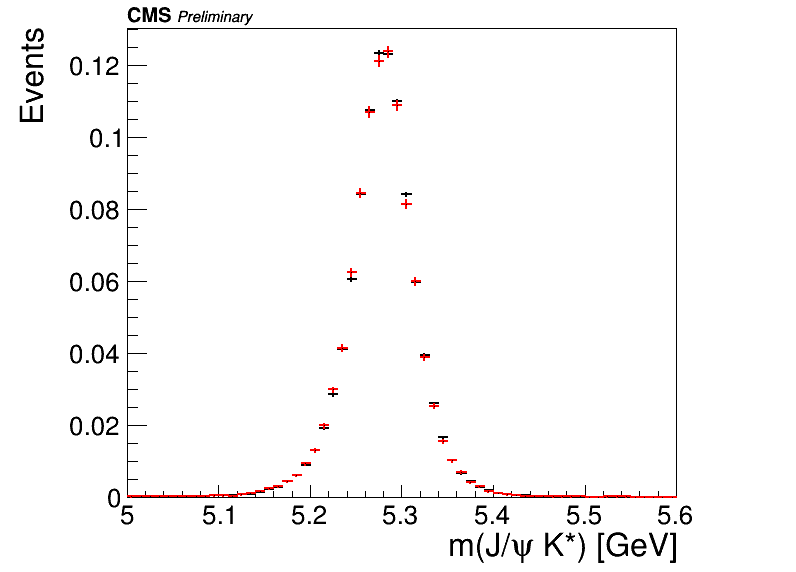

In [27]:
h = create_TH1D(d['mass_mumupiK'][sel_an], 
                title='',
                axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[60,5, 5.6]
               )
h.Sumw2()
h.Scale(1./h.Integral())

h2 = create_TH1D(dPU['mass_mumupiK'][sel_anPU], 
                title='',
                axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=h.binning
               )
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(2)
                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
c.SetRightMargin(0.15)
c.Draw()

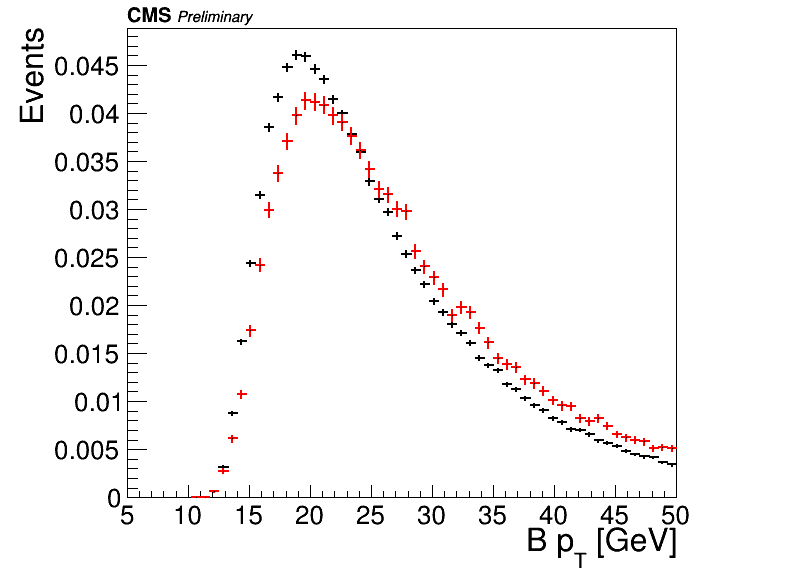

In [28]:
h = create_TH1D(d['B_mumupiK_pt'][sel_an], 
                title='',
                axis_title=['B p_{T} [GeV]', 'Events'],
                binning=[60,5, 50]
               )
h.Sumw2()
h.Scale(1./h.Integral())

h2 = create_TH1D(dPU['B_mumupiK_pt'][sel_anPU], 
                title='',
                binning=h.binning
               )
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(2)
                                   
c = drawOnCMSCanvas(CMS_lumi, [h, h2], 'same')
c.SetRightMargin(0.15)
c.Draw()

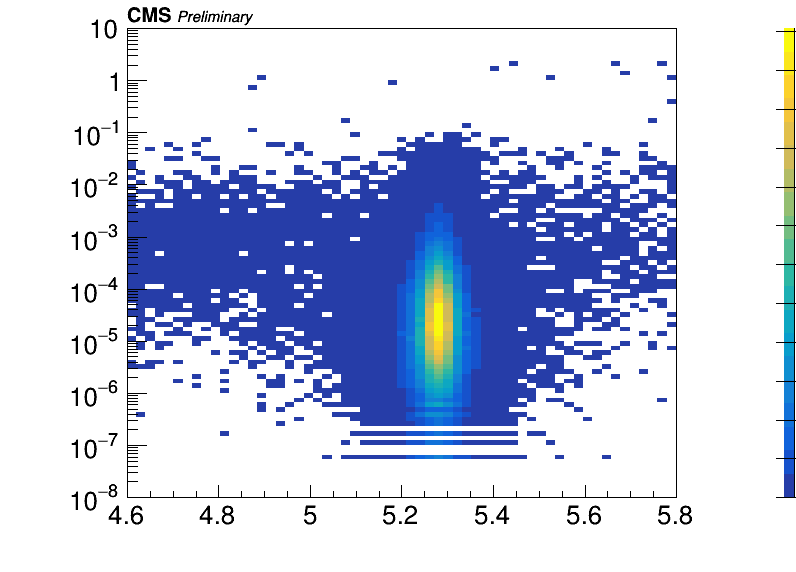

In [29]:
h = create_TH2D(np.column_stack((d['mass_mumupiK'][sel_an], 1-d['cos_B_PV_mumupiK'][sel_an])), 
                title='',
#                 axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[np.linspace(4.6, 5.8, 60), np.logspace(-8, 1, 100)]
               )

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'])
c.SetRightMargin(0.15)
c.SetLogy()
c.Draw()

In [30]:
cut['cos_B_PV_mumupiK'] = ['>',  0.99]
sel_an_imp, eff = createSel(d, cut)
print eff

0.3621899088694084


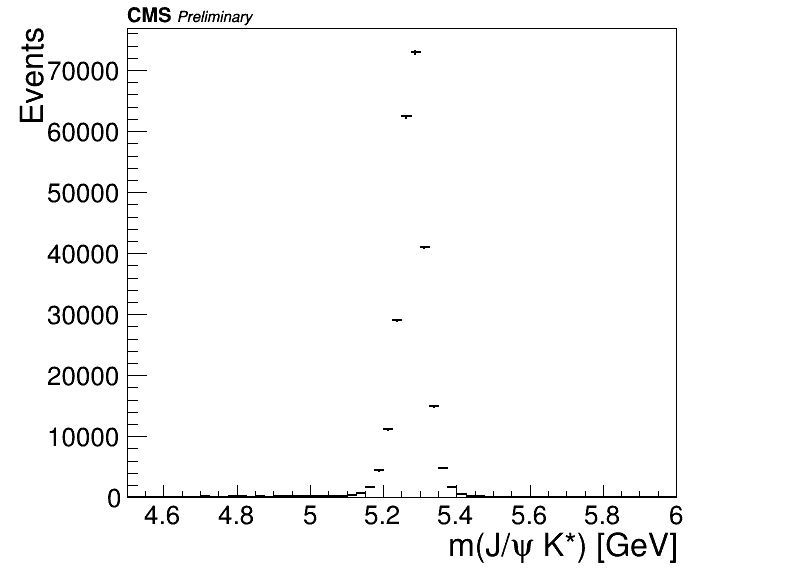

In [31]:
h = create_TH1D(d['mass_mumupiK'][sel_an_imp], 
                title='',
                axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[60,4.5, 6]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
c.Draw()